In [29]:
import pandas as pd
import pickle
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, LSTM, InputLayer, Bidirectional, TimeDistributed, Embedding, Activation,Dropout
from keras.optimizers import Adam
import numpy as np
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
import math
import keras_metrics

In [3]:
def readFile(fileName,sheet):
    xl_file = pd.read_excel(fileName,sheet)
    df = pd.DataFrame(xl_file, columns= ['Sentence #','Word','POS','Tag'])
    df = df.fillna(method='ffill')
    return df

In [4]:
def readTestFile(fileName,sheet):
    xl_file = pd.read_excel(fileName,sheet, header=None)
    df = pd.DataFrame(xl_file)
    df = df.fillna(method='ffill')
    df = df.drop(columns=[3,4,5])
    return df

In [5]:
df  = readFile('Rnn_train.xlsx','Sheet1')
dftest = readTestFile('Rnn_test.xlsx','Sheet1')

In [6]:
xl_file = pd.read_excel('pos_list.xlsx')

In [7]:
tag = pd.DataFrame(xl_file, columns= ['POS_list'])

In [8]:
#if create it call loadSentenceAndTags function 
def createSentenceAndTags(df):
    sentences = []
    sentence_tags = []
    for i in range(1,20000):
        sent = df[df['Sentence #']== ('Sentence: '+str(i))]
        sentences.append(sent['Word'])
        sentence_tags.append(sent['POS'])
    with open('sentences.data', 'wb') as filehandle:
        # store the data as binary data stream
        pickle.dump(sentences, filehandle)
    with open('sentence_tags.data', 'wb') as filehandle:
        # store the data as binary data stream
        pickle.dump(sentence_tags, filehandle)

In [9]:
def loadSentenceAndTags():
    with open('sentences.data', 'rb') as filehandle:
        # read the data as binary data stream
        sentences = pickle.load(filehandle)
    with open('sentence_tags.data', 'rb') as filehandle:
        # read the data as binary data stream
        sentence_tags = pickle.load(filehandle)
    return sentences,sentence_tags

In [10]:
# createSentenceAndTags(df)
sentences,sentence_tags = loadSentenceAndTags()

In [11]:
#if create it call loadSentenceAndTags function 
def createTestSentenceAndTags(df):
    sentences = []
    sentence_tags = []
    for i in range(20001,25001):
        sent = df[df[0]== ('Sentence: '+str(i))]
        sentences.append(sent[1])
        sentence_tags.append(sent[2])
    return sentences,sentence_tags

In [12]:
testSentences,testSentence_tags = createTestSentenceAndTags(dftest)

In [49]:
words = set([])
tags = set(tag['POS_list'])
def sentenceToPadSequence(sentences,sentence_tags):
    
    for s in sentences:
        for w in s:
            words.add(str(w).lower())

    wordCoding = {w: i + 1 for i, w in enumerate(list(words))}
    wordCoding['-unk-'] = 0       
    tagCoding = {t: i for i, t in enumerate(list(tags))}
    
    train_X = []
    labels = []
    for sent in sentences:
        x = []
        for word in sent:
            x.append(wordCoding[str(word).lower()])
        train_X.append(x)

    for sent in sentence_tags:
        labels.append([tagCoding[tag] for tag in sent])

    train_X = pad_sequences(train_X, maxlen=len(max(train_X, key=len)), padding='post')
    labels = pad_sequences(labels, maxlen=len(max(train_X, key=len)), padding='post')
    
    return train_X,labels,tagCoding,wordCoding

In [50]:
train_X,labels,tagCoding,wordCoding = sentenceToPadSequence(sentences,sentence_tags)
maxLen = len(max(train_X, key=len))

In [15]:
train_X.shape

(19999, 70)

In [16]:
labels.shape

(19999, 70)

In [17]:
def testsentenceToPadSequence(sentences,sentence_tags):
    train_X = []
    labels = []
    for sent in sentences:
        x = []
        for word in sent:
            try:
                x.append(wordCoding[str(word).lower()])
            except KeyError:
                x.append(wordCoding['-unk-'])
        train_X.append(x)

    for sent in sentence_tags:
        labels.append([tagCoding[tag] for tag in sent])

    train_X = pad_sequences(train_X, maxlen=maxLen, padding='post')
    labels = pad_sequences(labels, maxlen=maxLen, padding='post')
    
    return train_X,labels

In [18]:
test_X,testlabels = testsentenceToPadSequence(testSentences,testSentence_tags)

In [19]:
labels.shape

(19999, 70)

In [20]:
test_X.shape

(5000, 70)

In [30]:
def createModel():
    model = Sequential()
    model.add(InputLayer(input_shape=(maxLen, )))
    model.add(Embedding(len(wordCoding), 128))
    model.add(Bidirectional(LSTM(256, return_sequences=True,dropout=0.1, recurrent_dropout=0.1)))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(42, activation='softmax'))
    model.compile(loss='categorical_crossentropy',optimizer=Adam(0.002),metrics=[keras_metrics.precision(), keras_metrics.recall(),'accuracy'])
    print(model.summary())
    return model

In [22]:
ctLabels = to_categorical(labels, num_classes=42)

In [31]:
model  = createModel()
trained_model = model.fit(train_X, ctLabels, batch_size=512, epochs=8, validation_split=0.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 70, 128)           2703488   
_________________________________________________________________
bidirectional_4 (Bidirection (None, 70, 512)           788480    
_________________________________________________________________
dense_7 (Dense)              (None, 70, 128)           65664     
_________________________________________________________________
dropout_4 (Dropout)          (None, 70, 128)           0         
_________________________________________________________________
dense_8 (Dense)              (None, 70, 42)            5418      
Total params: 3,563,050
Trainable params: 3,563,050
Non-trainable params: 0
_________________________________________________________________
None
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
T

In [35]:
cttestLabels = to_categorical(testlabels, num_classes=42)
loss,precision , recall , acc = model.evaluate(test_X, cttestLabels)
print('loss = ',loss,'acc = ',acc,' precision = ',precision , 'recall = ',recall)

5000/5000 [==============================] - 16s 3ms/step
loss =  0.16097455946207045 acc =  0.9786485710144043  precision =  0.9926917402027482 recall =  0.9989406259710251


In [36]:
history=trained_model.history

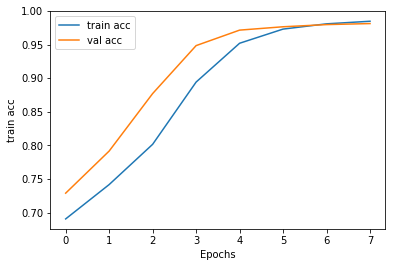

In [39]:

precision=history['precision']
val_precision=history['val_precision']
acc = history['acc']
val_acc = history['val_acc']
recall=history['recall']
val_recall=history['val_recall']

plt.xlabel('Epochs')
plt.ylabel('train acc')
plt.plot(acc)

plt.xlabel('Epochs')
# plt.ylabel('test acc')
plt.plot(val_acc)
plt.legend(['train acc','val acc'])

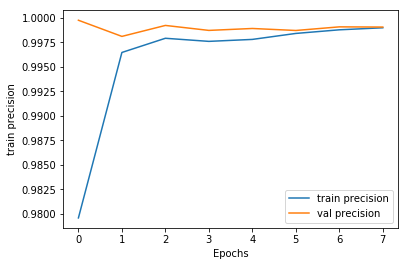

In [40]:
plt.xlabel('Epochs')
plt.ylabel('train precision')
plt.plot(precision)

plt.xlabel('Epochs')
# plt.ylabel('test acc')
plt.plot(val_precision)
plt.legend(['train precision','val precision'])

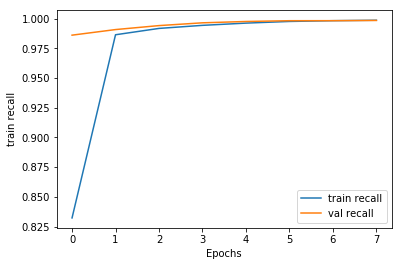

In [41]:
plt.xlabel('Epochs')
plt.ylabel('train recall')
plt.plot(recall)

plt.xlabel('Epochs')
# plt.ylabel('test acc')
plt.plot(val_recall)
plt.legend(['train recall','val recall'])

In [44]:
pred = model.predict_classes(test_X)

In [80]:
predict = []
w = list(words)
for i in range(len(testSentences)):
    for j in range(len(testSentences[i])):
        if(j<70):
            key_list = list(tagCoding.keys()) 
            predict.append(key_list[pred[i][j]])
        else:
            predict.append('-unk-')

In [82]:
dftest['result'] = predict

In [83]:
writer = pd.ExcelWriter('outputRNN.xlsx')
# write dataframe to excel
dftest.to_excel(writer)
# save the excel
writer.save()